# A benchmark Pairs Trading strategy 

This notebook explores a pairs trading strategy using bollinger bands. This projected is being developed as part of a master thesis for the degree of Electrical and Computer Engineering.

**Author:** Simão Moraes Sarmento <br /> 
**Contact:** simaosarmento@hotmail.com

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset examples, rather than coding the strategies theirselves. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [30]:
import numpy as np
import pandas as pd
import pickle

import json

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Import Datetime and the Pandas DataReader
from datetime import datetime
from pandas_datareader import data, wb

# Import alpha vantage
from alpha_vantage.timeseries import TimeSeries

# Import scikit instruments
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

# just set the seed for the random number generator
np.random.seed(107)

### Import Configurations

In [31]:
config_file = 'config/config_commodities_2010_2019.json'

In [32]:
with open(config_file, 'r') as f:
    config = json.load(f)

### Import Classes

In [33]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [35]:
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_long_updated')

In [36]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2009',
                                                             '31-12-2017'),
                                                            ('01-01-2018',
                                                             '31-12-2018'),
                                                            remove_nan=True)

Total of 208 tickers
Total of 71 tickers after removing tickers with Nan values


In [37]:
len(df_prices_train)+len(df_prices_test)

2516

# Load Pairs

In [38]:
with open('data/etfs/pickle/pairs_unsupervised_learning.pickle', 'rb') as handle:
    pairs = pickle.load(handle)

#with open('data/etfs/pickle/pairs_category.pickle', 'rb') as handle:
#    pairs = pickle.load(handle)

In [39]:
lookback_multiplier= config['trading']['lookback_multiplier']
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
# obtain trading filter info
if config['trading_filter']['active'] == 1:
    trading_filter = config['trading_filter']
else:
    trading_filter = None

In [40]:
n_years_train = round(len(df_prices_train)/240)
n_years_train

9

# Apply trading strategies

**Applying Bollinger Bands**

In [41]:
sharpe_results_bollinger, cum_returns_bollinger, performance_bollinger = trader.apply_bollinger_strategy(pairs,
                                                                                         lookback_multiplier,
                                                                                         entry_multiplier,
                                                                                         exit_multiplier,
                                                                                         trading_filter,
                                                                                         test_mode=False
                                                                                         )

**Bollinger Bands Performance**

In [42]:
avg_sharpe_bollinger, total_roi_bollinger, anual_roi_bollinger, positive_pct_bollinger = \
    trader.calculate_metrics(sharpe_results_bollinger, cum_returns_bollinger, n_years_train)

Average result:  0.08809343632312153
avg_total_roi:  -9.39016128090814
avg_annual_roi:  -1.0896573485117744
58.8235294117647 % of the pairs had positive returns


**Applying the Kalman filter based strategy**

In [43]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
sharpe_results_kalman, cum_returns_kalman, performance_kalman = trader.apply_kalman_strategy(pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=False)

In [44]:
avg_sharpe_kalman, total_roi_kalman, anual_roi_kalman, positive_pct_kalman = \
    trader.calculate_metrics(sharpe_results_kalman, cum_returns_kalman, n_years_train)

Average result:  5.644101670828193
avg_total_roi:  13856.040937177115
avg_annual_roi:  73.10392487294122
94.11764705882354 % of the pairs had positive returns


Sharpe Ratio Distribution: 


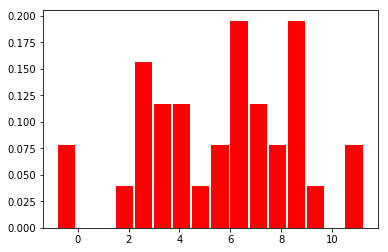

In [45]:
print('Sharpe Ratio Distribution: ')
n, bins, patches = plt.hist(sharpe_results_kalman, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')

## Some remarks

- From the analysis above, the Kalman filter method obtains the best performance, with an average Sharpe Ratio larger than 1.
- We should compare this approach with a *compare all against all* approach, to see by which factor our results are improved due to the clustering technique.

# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. 

We proceed with some data exploration analysis. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer to apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [46]:
n_years_test = round(len(df_prices_test)/240)
n_years_test

1

### Approach 1: Keeping every pair

**Bollinger Bands Out-of-Sample**

In [47]:
sharpe_results_bollinger_test, cum_returns_bollinger_test, performance_bollinger_test =\
                                    trader.apply_bollinger_strategy(pairs,
                                                                    lookback_multiplier,
                                                                    entry_multiplier,
                                                                    exit_multiplier,
                                                                    trading_filter,
                                                                    test_mode = True
                                                                    )

In [48]:
avg_sharpe_bollinger_test, total_roi_bollinger_test, anual_roi_bollinger_test, positive_pct_bollinger_test = \
    trader.calculate_metrics(sharpe_results_bollinger_test, cum_returns_bollinger_test, n_years_test)

Average result:  0.40034242963125866
avg_total_roi:  5.721389147341722
avg_annual_roi:  5.721389147341727
76.47058823529412 % of the pairs had positive returns


**Kalman Out-of-Sample**

In [49]:
sharpe_results_kalman_test, cum_returns_kalman_test, performance_kalman_test = trader.apply_kalman_strategy(pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=True)

In [50]:
avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
        trader.calculate_metrics(sharpe_results_kalman_test, cum_returns_kalman_test, n_years_test)

Average result:  1.7901590178955478
avg_total_roi:  26.52963234321774
avg_annual_roi:  26.529632343217745
94.11764705882354 % of the pairs had positive returns


### Approach 2: Keeping only pairs that had positive returns in the training period

**Bollinger Strategy**

In [51]:
sharpe_results_bollinger = np.asarray(sharpe_results_bollinger)
profitable_pairs_indices = np.argwhere(sharpe_results_bollinger > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [52]:
sharpe_results_bollinger_test, cum_returns_bollinger_test, performance_bollinger_test =\
                                    trader.apply_bollinger_strategy(profitable_pairs,
                                                                    lookback_multiplier,
                                                                    entry_multiplier,
                                                                    exit_multiplier,
                                                                    trading_filter,
                                                                    test_mode = True)

In [53]:
avg_sharpe_bollinger_test, total_roi_bollinger_test, anual_roi_bollinger_test, positive_pct_bollinger_test = \
    trader.calculate_metrics(sharpe_results_bollinger_test, cum_returns_bollinger_test, n_years_test)

Average result:  0.40201382402283026
avg_total_roi:  6.873636953746609
avg_annual_roi:  6.873636953746609
75.0 % of the pairs had positive returns


**Kalman Strategy**

In [54]:
sharpe_results_kalman = np.asarray(sharpe_results_kalman)
profitable_pairs_indices = np.argwhere(sharpe_results_kalman > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [55]:
sharpe_results_kalman_test, cum_returns_kalman_test, performance_kalman_test = trader.apply_kalman_strategy(\
                                                                                             profitable_pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=True)

In [56]:
avg_sharpe_kalman_test, total_roi_kalman_test, anual_roi_kalman_test, positive_pct_kalman_test = \
    trader.calculate_metrics(sharpe_results_kalman_test, cum_returns_kalman_test, n_years_test)

Average result:  1.8416829371242054
avg_total_roi:  27.648145500200386
avg_annual_roi:  27.648145500200382
93.75 % of the pairs had positive returns


We can conclude that the 2nd approach presents better results. From now on, we assume the 2nd approach was taken.

# Validate the results

The results obtained are suspiciously high. We pretend to look deeper into the numbers.

In [57]:
with open(config['dataset']['ticker_segment_dict'], 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)
results, pairs_summary = trader.summarize_results(sharpe_results_kalman_test, cum_returns_kalman_test,
                                                  performance_kalman_test, profitable_pairs, ticker_segment_dict)

Average result:  1.8416829371242054
avg_total_roi:  27.648145500200386
avg_annual_roi:  27.648145500200382
93.75 % of the pairs had positive returns


In [58]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,FUE,Commodities: Agriculture Grains,RJI,Commodities: Broad Market,-3.024221,0.032694,114,19,0.306913,40,13,3.103910,75.471698
1,FUE,Commodities: Agriculture Grains,RJZ,Commodities: Broad Market Metals,-2.870450,0.048894,87,37,0.340088,52,15,2.961096,77.611940
2,FUE,Commodities: Agriculture Grains,LD,Commodities: Industrial Metals Lead,-3.547390,0.006850,81,44,0.350501,35,11,2.910385,76.086957
3,FUE,Commodities: Agriculture Grains,RJA,Commodities: Agriculture,-3.526155,0.007340,142,13,0.199388,34,11,2.875192,75.555556
4,FUE,Commodities: Agriculture Grains,GRU,Commodities: Agriculture Grains,-3.911956,0.001949,171,16,0.214385,41,20,2.850105,67.213115
5,FUD,Commodities: Agriculture,GRU,Commodities: Agriculture Grains,-3.462353,0.009008,81,42,0.366386,61,21,2.768138,74.390244
6,SLV,Commodities: Precious Metals Silver,UBG,Commodities: Precious Metals Gold,-3.089587,0.027333,113,32,0.397103,70,26,2.760451,72.916667
7,FUE,Commodities: Agriculture Grains,GSC,Commodities: Broad Market,-2.954870,0.039329,98,25,0.338285,23,6,2.647978,79.310345
8,GRU,Commodities: Agriculture Grains,UAG,Commodities: Agriculture,-3.320260,0.013997,101,46,0.385086,56,20,2.419975,73.684211
9,GSC,Commodities: Broad Market,GSP,Commodities: Broad Market,-4.015373,0.001332,189,9,0.165446,95,14,2.388995,87.155963


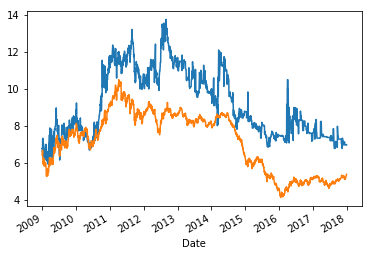

In [95]:
index = 20
performance_kalman[index][1]['FUE'].plot()
performance_kalman[index][1]['RJI'].plot()
#[performance_kalman_test[index][1].ret != 0]
#(np.cumprod(1 + performance_kalman_test[index][1].ret) - 1).iloc[-1] * 100

In [42]:
index = 3
performance_bollinger_test[index][1]['2018-02-28':].head()#[performance_kalman_test[index][1].ret != 0]
#(np.cumprod(1 + performance_bollinger_test[index][1].ret) - 1).iloc[-1] * 100

,pnl,ret,FUE,RJA,beta,spread,zscore,current_position,position_return_(%)
2018-02-28,0.000000,0.000000,6.91,6.35,-1.301899,15.177059,1.983318,0.0,0.0
2018-03-01,-0.511133,-0.033678,7.33,6.42,-1.260405,15.421803,1.756506,-1.0,0.0
2018-03-02,0.525624,0.034083,6.88,6.36,-0.462475,9.821342,0.874462,-1.0,0.0
2018-03-05,-0.036998,-0.003767,6.88,6.44,-0.632532,10.953503,0.961267,-1.0,0.0
2018-03-06,0.012651,0.001155,6.88,6.42,-0.663953,11.142575,0.909020,-1.0,0.0


**Controlling for range of returns**

In [32]:
print('Maximum return obtained in a single trade, per pair')
for i in range(len(profitable_pairs)):
    print(performance_kalman_test[i][1]['position_return_(%)'].max())

Maximum return obtained in a single trade, per pair
6.909643329707249
2.344319660257277
6.325049465710242
6.860857673435539
7.7576502921139046
0.5472888742080073
4.719338412152352
4.588519787256695
1.9119661476994176
2.5717140926448057
3.6115280102167358
6.344712404353237
8.944771315862665
6.770436995676965
7.872547354205239
0
0.603724342557066
7.4551148557032265
2.1992877949544187
1.3714593365384387
1.1169718070006773
7.473367817498389
8.793958998520024
7.847044174543161
2.362776294397251
1.7495892510591249
2.9713087148948603


In [33]:
print('Worst return obtained in a single trade, per pair')
for i in range(len(profitable_pairs)):
    print(performance_kalman_test[i][1]['position_return_(%)'].min())

Worst return obtained in a single trade, per pair
-1.6911257178030437
-2.5716237277046194
-1.396548093702843
-1.5213508400645726
-2.602345414307572
0.0
-5.147165474636695
-3.593443943742247
-2.7125628795925505
-4.3052777853785695
-3.836767909719385
-15.447270551358494
-12.529718632368391
-14.662036092456832
-14.45972086192998
0
-0.8524721002408753
-11.379207839522277
-1.7291765129797576
0.0
-1.178545620649185
-14.496690367595356
-21.51140530231296
-14.501701046026216
-6.038117635525553
-2.324922501050386
-8.528108800685818


Tanto as returns máximas como as mínimas parecem ter valores dentro da normalidade.

## Training vs Validation

For a far comparison, we should compare the test resuls with the results obtained in the training set, but also using only the profitable pairs:

In [34]:
entry_multiplier= config['trading']['entry_multiplier']
exit_multiplier= config['trading']['exit_multiplier']
sharpe_results_kalman, cum_returns_kalman, performance_kalman = trader.apply_kalman_strategy(profitable_pairs, 
                                                                                             entry_multiplier,
                                                                                             exit_multiplier,
                                                                                             trading_filter,
                                                                                             test_mode=False)
avg_sharpe_kalman, total_roi_kalman, anual_roi_kalman, positive_pct_kalman = \
    trader.calculate_metrics(sharpe_results_kalman, cum_returns_kalman, n_years_train)

Average result:  3.9480398122265092
avg_total_roi:  13214.915149711247
avg_annual_roi:  72.20176574126901
100.0 % of the pairs had positive returns


In [35]:
print('The sharpe ratio obtained in the training set with the pairs used on the test set is ', avg_sharpe_kalman)
print('The sharpe ratio obtained in the test set is ', avg_sharpe_kalman_test)

The sharpe ratio obtained in the training set with the pairs used on the test set is  3.9480398122265092
The sharpe ratio obtained in the test set is  1.3171267445846853


As expected, the sharpe ratio is indeed higher in the training set.

In [36]:
len(pairs)

33

In [37]:
len(profitable_pairs)

27

## Analyzing Pairs' Overlap

There could be two possible interpretations for pairs' overlap.
1. We might be interested in checking which of the cointegrated pairs found in the training dataset are also cointegrated in the test set; Furthermore we want to explore how the two types of pairs perform.
2. We might be interested in finding if the pairs that would have been found in the test set by performing PCA + clustering would be cointegrated in the training set.

Starting with **1)**, let's see how many of the identified pairs actually turned out to be cointegrated during this period.

In [38]:
pairs_overlapped, pairs_overlapped_index = series_analyser.pairs_overlap(pairs,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs identified in the training set are also cointegrated in the test set'.format(\
    len(pairs_overlapped), len(pairs)))

4 of the 33 pairs identified in the training set are also cointegrated in the test set


In [39]:
profitable_pairs_overlapped, profitable_pairs_overlapped_index = series_analyser.pairs_overlap(profitable_pairs,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs with positive returns identified in the training set are also cointegrated in the test set'.format(\
    len(profitable_pairs_overlapped), len(profitable_pairs)))

2 of the 27 pairs with positive returns identified in the training set are also cointegrated in the test set


### Is cointegration really important?

To answer this question we will see how many of the still cointegrated pairs had positive and negative returns. We will then do the same for those pairs that were not cointegrated. 

If both are as likely to have positive and negative returns, then it means cointegration is not as important of a condition. On the other hand, if we verify that all pairs that are still cointegrated turned out to be profitable and those that are not anymore led to consistent negative returns, we can infer that cointegration is a very important predictor of future returns.

We also compare the average performance of the two groups two see the relevance of being cointegrated with respect to the sharpe ratio obtained.

*Still cointegrated*

In [40]:
# distribution for pairs which were cointegrated in train and test
sharpe_results_pairs_overlapped = np.asarray([sharpe_results_kalman_test[index] for index \
                                              in profitable_pairs_overlapped_index])
cum_returns_pairs_overlapped = np.asarray([cum_returns_kalman_test[index] for index \
                                              in profitable_pairs_overlapped_index])

if len(sharpe_results_pairs_overlapped)>0:
    _,_,_,_ = trader.calculate_metrics(sharpe_results_pairs_overlapped, cum_returns_pairs_overlapped,
                                   n_years_test)
else:
    print('0% of the pairs cointegrated in the train are also cointegrated in the test set')

Average result:  1.7479555681745413
avg_total_roi:  17.128817803477034
avg_annual_roi:  17.128817803477038
100.0 % of the pairs had positive returns


*Not cointegrated anymore*

In [41]:
# distribution for pairs which were cointegrated in train but not in test
profitable_pairs_not_overlapped_index = [i for i in np.arange(0,len(profitable_pairs))\
                                         if i not in profitable_pairs_overlapped_index]

sharpe_results_pairs_not_overlapped = np.asarray([sharpe_results_kalman_test[index] for index \
                                              in profitable_pairs_not_overlapped_index])

cum_returns_pairs_not_overlapped = np.asarray([cum_returns_kalman_test[index] for index \
                                              in profitable_pairs_not_overlapped_index])

_,_,_,_ = trader.calculate_metrics(sharpe_results_pairs_not_overlapped, cum_returns_pairs_not_overlapped,
                                   n_years_test)

Average result:  1.2826604386974967
avg_total_roi:  24.34169502419012
avg_annual_roi:  24.341695024190123
92.0 % of the pairs had positive returns


Answering to the first question we were concerned with, we verify that a cointegrated pair is indeed more likely to have a positive return. Furthermore, we can conclude from the results that being cointegrated implied that those pairs generated higher returns. 

**TO REVIEW:Conclusion**: The fact that a pair is not cointegrated anymore does not impact the results obained. In fact, we just concluded that betting solely on the cointegrated pairs would yield a worse result. Therefore, we should not spend much effort in detecting pairs that are no cointegrated anymore.

Following with point number **2)**, we proceed to analyze the performance of the pairs that woud have been identified in the testing period.

In [42]:
initial_test_date = config['dataset']['testing_initial_date']
final_teste_date = config['dataset']['testing_final_date']

# Get returns for test period
df_returns_test = data_processor.get_return_series(df_prices_test)

# APPLY PCA and CLUSTERING
range_n_components = config['PCA']['N_COMPONENTS']
X_test, clustered_series_all_test, clustered_series_test, counts_test, clf_test = \
            series_analyser.clustering_for_optimal_PCA(range_n_components[0], range_n_components[1],
                                                       df_returns_test, config['clustering'])
# Find pairs
pairs_test, unique_tickers_test = series_analyser.get_candidate_pairs(\
                                            clustered_series=clustered_series_test,
                                            pricing_df_train=df_prices_test,
                                            pricing_df_test=df_prices_train,
                                            min_half_life=config['pair_restrictions']['min_half_life'],
                                            min_zero_crosings=config['pair_restrictions']['min_zero_crossings'],
                                            p_value_threshold=config['pair_restrictions']['p_value_threshold'],
                                            hurst_threshold=config['pair_restrictions']['hurst_threshold']
                                            )

# Finally, see overlap
pairs_overlapped, pairs_overlapped_index = series_analyser.pairs_overlap(pairs_test,
                                  config['pair_restrictions']['p_value_threshold'],
                                  config['pair_restrictions']['min_zero_crossings'],
                                  config['pair_restrictions']['min_half_life'],
                                  config['pair_restrictions']['hurst_threshold'])
print('{} of the {} pairs identified in the test set are also cointegrated in the training set'.format(\
    len(pairs_overlapped), len(pairs_test)))


Number of components:  10
Returns shape:  (250, 71)
Clusters discovered: 7
Pairs to evaluate: 16
Silhouette score  -0.16573849480651415

Number of components:  11
Returns shape:  (250, 71)
Clusters discovered: 7
Pairs to evaluate: 16
Silhouette score  -0.16509632505521246

Number of components:  12
Returns shape:  (250, 71)
Clusters discovered: 6
Pairs to evaluate: 13
Silhouette score  -0.19695784214924508

Number of components:  13
Returns shape:  (250, 71)
Clusters discovered: 5
Pairs to evaluate: 9
Silhouette score  -0.20569116834384663

Number of components:  14
Returns shape:  (250, 71)
Clusters discovered: 4
Pairs to evaluate: 8
Silhouette score  -0.1977134047270998

The best silhouette coefficient was: -0.16509632505521246 for 11 principal components
Found 2 pairs
The pairs contain 4 unique tickers
1 of the 2 pairs identified in the test set are also cointegrated in the training set


Let's see if the pairs identified in the test period lead indeed to improved results:

In [43]:
sharpe_results_kalman_test_newpairs, cum_returns_kalman_test_newpairs, performance_kalman_test_newpairs =\
    trader.apply_kalman_strategy(pairs_test, entry_multiplier,exit_multiplier,trading_filter, test_mode=False)

_,_,_,_ = trader.calculate_metrics(sharpe_results_kalman_test_newpairs, cum_returns_kalman_test_newpairs,
                                   n_years_test)

Average result:  1.3850770707572364
avg_total_roi:  1.1660881620394137
avg_annual_roi:  1.1660881620394026
50.0 % of the pairs had positive returns


The sharpe ratio is higher in this scenatio. Note hoewever, that the annual ROI is not so high as the pairs identified previously. This might be linked with the fact that these pairs did not prove to be cointegrated for a period as long as the other and therefore the pairs might be less stable.

## Analyzing the influence of pairs statistics

It's interesting to analyze whether we could have used extra information from the pairs trading statistic, instead of considering it just as a pass or not pass test. `Law 2017` explore this concept on their paper (htey basically rank pairs according to a trade off between t-statistic and spread deviation from its mean). However, what we see below is that there is no obvious influence of any parameter in the performance of the corresponding pair.

In [44]:
pairs_summary.corr()[['sharpe_result', 'positive_trades_per_pair_pct']].loc[['t_statistic', 'p_value',
                                                                             'zero_cross', 'half_life',
                                                                             'hurst_exponent']]

,sharpe_result,positive_trades_per_pair_pct
t_statistic,0.601476,0.565698
p_value,0.461473,0.657006
zero_cross,0.332275,0.113088
half_life,-0.140625,-0.202277
hurst_exponent,-0.134503,-0.101301


### The Correlation Filter

The correlation filter aims to track how the correlation between the two legs of tha pair is varing, and provide that information as input to the trading strategy.

In [45]:
example_pair = failed_pairs[2]

example_pair_leg1 = example_pair[0][0]
example_pair_leg2 = example_pair[0][1]

example_pair_prices = etfs_pricing[[example_pair_leg1, example_pair_leg2]]
example_pair_prices.plot(figsize=(15,5))


# proceed to calculate correlation
rolling_window = config['trading']['lookback_multiplier']*example_pair[0][2]['half_life']

# get returns
example_pair_returns = data_processor.get_return_series(example_pair_prices)

# analyze correlation on returns
example_correlation = example_pair_returns[example_pair_leg1].rolling(rolling_window).corr(example_pair_returns[example_pair_leg2])

# plot correlation of returns
diff_example_correlation = example_correlation.diff(periods=1)
#diff_example_correlation = diff_example_correlation*10
diff_example_correlation.plot()

NameError: name 'failed_pairs' is not defined

This result indicates there's almost no correlation between correlation diff and returns... Let's see how this result varies on average:

In [ ]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    correlation = failure_df['ret'].corr(failure_df['correlation'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

However, we are not realyy interested in the correlation of the the diff column, but rather on the correlation with its sign.

In [ ]:
failure_correlations = []
for failure in failed_pairs:
    failure_df = failure[1][failure[1].units != 0]
    failure_df['diff_correlation_sign']=failure_df['diff_correlation'].apply(lambda row: -1 if row<0 else 1)
    correlation = failure_df['ret'].corr(failure_df['diff_correlation_sign'])
    failure_correlations.append(correlation)
    
print(np.mean(failure_correlations))

We could use mutual information rather than correlation as the sign is discrete. What about the relation with the zscore evolution?

### Analyze non-profitable pairs

In [ ]:
sharpe_results_kalman_test = np.asarray(sharpe_results_kalman_test)
negative_pairs_indices = np.argwhere(sharpe_results_kalman_test < 0)
print('{} out of {} pairs turned out to be non-profitable'.format(len(negative_pairs_indices), len(pairs)))

Let's get some more information on the non-profitable pairs:

In [ ]:
negative_pairs = [pairs[i] for i in negative_pairs_indices.flatten()]
negative_pairs = [(item[0], item[1]) for item in negative_pairs]
negative_pairs

To what clusters do these pairs belong?

In [ ]:
for label_n in range(len(counts)):
    elements_cluster_n = list(clustered_series[clustered_series == label_n].index)
    etfs_cluster_n = etfs_unique[etfs_unique['Ticker'].isin(elements_cluster_n)]
    for pair in negative_pairs:
        if pair[0] in list(etfs_cluster_n.Ticker):
            print('Pair {} belongs to cluster {}'.format(pair, label_n))

How do the statistics rank?

In [ ]:
sorted_indices = np.flip(np.argsort(sharpe_results_bollinger), axis=0)

# initialize list of lists 
data = []
for index in sorted_indices:
    # get number of positive and negative positions
    position_returns = performance_bollinger[index][1].position_return
    positive_positions = len(position_returns[position_returns>0])
    negative_positions = len(position_returns[position_returns<0])
    data.append([pairs[index][0],
                 pairs[index][1],
                 pairs[index][2]['t_statistic'],
                 pairs[index][2]['p_value'],
                 pairs[index][2]['zero_cross'],
                 pairs[index][2]['half_life'],
                 pairs[index][2]['hurst_exponent'],
                 positive_positions,
                 negative_positions,
                 sharpe_results_bollinger[index]
                ])
      
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Leg1', 'Leg2', 't_statistic', 'p_value', 'zero_cross',
                                   'half_life', 'hurst_exponent', 'positive trades', 'negative_trades',
                                   'sharpe_result']) 
df

In [ ]:
df.half_life.mean()

In [ ]:
# analyze correlations
print('Half-life vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['half_life']))
print('Zero crossings vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['zero_cross']))
print('p-value vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['p_value']))
print('t-statistic vs Sharpe Ratio correlation: ', df['sharpe_result'].corr(df['t_statistic']))
print('Hurst exponent vs Sharpe Ratio correlation ', df['sharpe_result'].corr(df['hurst_exponent']))

Are there any signs these pairs were not profitable as the strategy evolves? Could we have predicted their lack of profitability?
- Using a ML algorithm that recognizes when a pair is not profitable anymore.
- Checking how the hurst exponent has been changing.
- Analyze their previous positions' returns